In [1]:
import numpy as np
import pandas as pd
import datetime
import pickle

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### Collecting the data using LA CITY DATA API 

The default API recommends using Socrata since it converts JSON to Python list of dictionaries. As a result, it can instantly be translated into a dataframe.
Using this, we imported 4 million of the 4.7million rows of data.

In [ ]:
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:

client = Socrata("data.lacity.org", None)


# Pull 4 million results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.

results = client.get("n44u-wxe4", limit=4_000_000)


# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [68]:
results_df.shape

(4000000, 11)

In [69]:
# results_df.to_csv('./data/LAFD_Raw_Response_Metrics_4mil.csv')

In [4]:
lafd= pd.read_csv('./data/LAFD_Raw_Response_Metrics_4mil.csv', index_col=0)
print(lafd.shape)
lafd.head()

/Users/jameslee/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(4000000, 11)


,dispatch_sequence,dispatch_status,emergency_dispatch_code,en_route_time_gmt,first_in_district,incident_creation_time_gmt,on_scene_time_gmt,ppe_level,randomized_incident_number,time_of_dispatch_gmt,unit_type
0,1,QTR,Emergency,08:04:25.938953,10.0,08:01:04.000000,08:08:30.677752,EMS,201301588315,08:02:21.320320,RA - ALS RESCUE AMBULANCE
1,2,QTR,Emergency,08:04:30.594473,52.0,08:00:56.000000,08:08:01.409394,EMS,201301588315,08:03:00.001407,E - ENGINE
2,3,QTR,Emergency,08:04:12.203676,52.0,08:00:56.000000,08:08:29.863091,EMS,201301588315,08:03:00.006304,RA - ALS RESCUE AMBULANCE
3,1,QTR,Emergency,08:04:11.383828,29.0,08:01:40.000000,08:08:51.592955,EMS,201301588316,08:02:58.285036,RA - ALS RESCUE AMBULANCE
4,2,QTR,Emergency,08:04:28.254742,29.0,08:01:40.000000,08:19:33.368940,EMS,201301588316,08:02:58.289767,RA8XX - BLS RESCUE AMBULANCE


In [6]:
lafd.isnull().sum()

dispatch_sequence                  0
dispatch_status                    0
emergency_dispatch_code            0
en_route_time_gmt             110020
first_in_district                425
incident_creation_time_gmt         0
on_scene_time_gmt             573804
ppe_level                          0
randomized_incident_number         0
time_of_dispatch_gmt               0
unit_type                          0
dtype: int64

**Emergency Dispatch Code**
* Indicates whether an incident was categorized as emergency or non-emergency. This dataset contains information related to emergency incidents only. As a result, we will remove this column as it adds no value.

**En Route Time (GMT)**
* "CAD captures the time when LAFD resources leave quarters by storing the time in which the corresponding key is pressed at the resource’s Mobile Data Computer (MDC)." Due to the fact that we will be trying to create a model that can predict reponse time which incorporates the en route time, we will remove any null values in this feature.

**On Scene Time (GMT)**
* "CAD captures the time when LAFD resources arrive at the scene of the incident when the corresponding key is pressed at the resource’s MDC." Due to the fact that we will be trying to create a model that can predict reponse time which incorporates the on scene time, we will remove any null values in this feature.

*"It must be noted that the recording of En Route Time and On-Scene Time is an event-driven process that requires first-responder interaction. The precision of those time stamps depends on the timeliness of when the user manually activates the respective function key on the MDC (Mobile Data Computer)."*

In [7]:
lafd.drop(columns='emergency_dispatch_code', inplace=True)
lafd.dropna(subset=['first_in_district', 'en_route_time_gmt', 'on_scene_time_gmt'], inplace=True)
lafd['first_in_district']= [int(i) for i in lafd['first_in_district']]

In [8]:
lafd.isnull().sum().sum()

0

In [9]:
print(lafd.shape)
lafd.head()

(3400480, 10)


,dispatch_sequence,dispatch_status,en_route_time_gmt,first_in_district,incident_creation_time_gmt,on_scene_time_gmt,ppe_level,randomized_incident_number,time_of_dispatch_gmt,unit_type
0,1,QTR,08:04:25.938953,10,08:01:04.000000,08:08:30.677752,EMS,201301588315,08:02:21.320320,RA - ALS RESCUE AMBULANCE
1,2,QTR,08:04:30.594473,52,08:00:56.000000,08:08:01.409394,EMS,201301588315,08:03:00.001407,E - ENGINE
2,3,QTR,08:04:12.203676,52,08:00:56.000000,08:08:29.863091,EMS,201301588315,08:03:00.006304,RA - ALS RESCUE AMBULANCE
3,1,QTR,08:04:11.383828,29,08:01:40.000000,08:08:51.592955,EMS,201301588316,08:02:58.285036,RA - ALS RESCUE AMBULANCE
4,2,QTR,08:04:28.254742,29,08:01:40.000000,08:19:33.368940,EMS,201301588316,08:02:58.289767,RA8XX - BLS RESCUE AMBULANCE


**First In District**
* "The location where the incident occurred in terms of a Fire Station district. The area where a particular fire station responds as well as where the incident occurred."
* There are 98 fire-stations in our dataset. All 98 fire-stations belong to a neighborhood council. 24 neighborhood councils have more than 1 fire-stations within its' boundaries. 

In [10]:
lafd['first_in_district'].unique()

array([ 10,  52,  29,  13,  95, 104,  93,  57,  79,  59,  65,  63,  20,
        81,  12,   2,  71,  37,  36,  64,  27,  74,  15,   4,  66,  72,
         9,  85, 107,  26,  21,  48,  34,  77,  94,  89,  98,  62, 109,
        14,  78,  43,  56,  92, 101,  61,  11,  58, 100,  83,  68,  38,
        75,  46,  67, 112,  18,  90,  39,   5,  19,  55,  88,  91,  84,
        82,  33, 106,  40,   8,   3,   1, 102,  44,  86,  41,  60, 105,
        47,   6,  96,  70,  35,  97,  17,  42,  69,  51,  87,  76, 103,
        23,   7,  73,  24,  25,  99,  50, 108,  28,  16,  49, 111, 110,
       122, 124, 123, 121, 125])

In [11]:
lafd['nc_name'] = lafd['first_in_district']

In [12]:
with open('./assets/reverse_dict.pkl','rb') as f:
    reverse_dict = pickle.load(f)

In [13]:
print(f'Number of fire-stations: {len(reverse_dict.keys())}')
print(f'Number of unique fire-stations: {len(set(reverse_dict.keys()))}')
print(f'Number of fire-stations in NCs: {len(reverse_dict.values())}')
print(f'Number of unique NCs with fire-stations: {len(set(reverse_dict.values()))}')
# this makes sense. 74 unique Neighborhood councils with at least 1 fire-station, 98 total number of fire stations among the neighborhood councils in the LA County. 
# 24 neighborhood councils have more than 1 fire stations within its' boundaries.

Number of fire-stations: 98
Number of unique fire-stations: 98
Number of fire-stations in NCs: 98
Number of unique NCs with fire-stations: 74


In [14]:
lafd['nc_name'] = lafd['first_in_district'].map(reverse_dict)

In [15]:
lafd.head()

,dispatch_sequence,dispatch_status,en_route_time_gmt,first_in_district,incident_creation_time_gmt,on_scene_time_gmt,ppe_level,randomized_incident_number,time_of_dispatch_gmt,unit_type,nc_name
0,1,QTR,08:04:25.938953,10,08:01:04.000000,08:08:30.677752,EMS,201301588315,08:02:21.320320,RA - ALS RESCUE AMBULANCE,DOWNTOWN LOS ANGELES
1,2,QTR,08:04:30.594473,52,08:00:56.000000,08:08:01.409394,EMS,201301588315,08:03:00.001407,E - ENGINE,HOLLYWOOD STUDIO DISTRICT NC
2,3,QTR,08:04:12.203676,52,08:00:56.000000,08:08:29.863091,EMS,201301588315,08:03:00.006304,RA - ALS RESCUE AMBULANCE,HOLLYWOOD STUDIO DISTRICT NC
3,1,QTR,08:04:11.383828,29,08:01:40.000000,08:08:51.592955,EMS,201301588316,08:02:58.285036,RA - ALS RESCUE AMBULANCE,GREATER WILSHIRE NC
4,2,QTR,08:04:28.254742,29,08:01:40.000000,08:19:33.368940,EMS,201301588316,08:02:58.289767,RA8XX - BLS RESCUE AMBULANCE,GREATER WILSHIRE NC


Around 190,000 incidents received a response from another fire-station department that is outside our range of Neighborhood Councils. As a result, we will drop those rows.

In [16]:
lafd.isnull().sum()

dispatch_sequence                  0
dispatch_status                    0
en_route_time_gmt                  0
first_in_district                  0
incident_creation_time_gmt         0
on_scene_time_gmt                  0
ppe_level                          0
randomized_incident_number         0
time_of_dispatch_gmt               0
unit_type                          0
nc_name                       189682
dtype: int64

In [17]:
lafd.dropna(axis=0, how='any', inplace=True)
lafd.shape

(3210798, 11)

In [18]:
lafd.isnull().sum().sum()

0

In [19]:
lafd.to_csv('./data/clean_LAFD_Raw_Response_Metrics_all_4mill.csv')

## LAFD Raw Response Metrics Data Exploration:

In the beginning of the data exploration, we will focus on the LAFD Raw Response Metrics.

#### Total Number of Incidents reported: 

According to this data, Downtown LA receives the most amount of LAFD emergency calls based on the timeline of this data (2013 to 2017). This makes sense as the population density in DTLA is most likely higher than any other city region within the LA County. A lot of the Neighborhood Councils reported among the top 10 most LAFD emergency calls are from "less-affluent" neighborhoods in LA. 
On the other hand, the least amount of LAFD emergency calls are from the area of Bel-Air Beverly. Compared to DTLA, Bel-Air is a much more affluent neighborhood in LA and the population density is much smaller. Most of the lower emergency incident locations are in the San Fernando Valley area or North East LA area.

In [20]:
top_10_nc_response = lafd.groupby('nc_name')['first_in_district'].count().sort_values(ascending=False).head(10)
bottom_10_nc_response = lafd.groupby('nc_name')['first_in_district'].count().sort_values().head(10).sort_values(ascending=False)

In [21]:
top_10_nc_response

nc_name
DOWNTOWN LOS ANGELES                                                                                225969
NC WESTCHESTER/PLAYA                                                                                108638
EMPOWERMENT CONGRESS SOUTHEAST AREA NDC                                                             101162
UNITED NEIGHBORHOODS OF THE HISTORIC ARLINGTON HEIGHTS, WEST ADAMS, AND JEFFERSON PARK COMMUNITY     90980
EMPOWERMENT CONGRESS CENTRAL AREA NDC                                                                89631
VOICES OF 90037                                                                                      76733
WESTLAKE SOUTH NC                                                                                    76566
SHERMAN OAKS NC                                                                                      73571
COMMUNITY AND NEIGHBORS FOR NINTH DISTRICT UNITY (CANNDU)                                            68627
NORTH HOLLYWOOD NORTHEAST NC 

In [22]:
bottom_10_nc_response

nc_name
NORTHRIDGE SOUTH NC         20973
SILVER LAKE NC              18724
HARBOR GATEWAY SOUTH NC     18256
NORTHWEST SAN PEDRO NC      15842
PORTER RANCH NC             14408
GRANADA HILLS NORTH NC      13457
GLASSELL PARK NC            12923
GREATER CYPRESS PARK NC     12837
COASTAL SAN PEDRO NC        10202
BEL AIR-BEVERLY CREST NC     2348
Name: first_in_district, dtype: int64

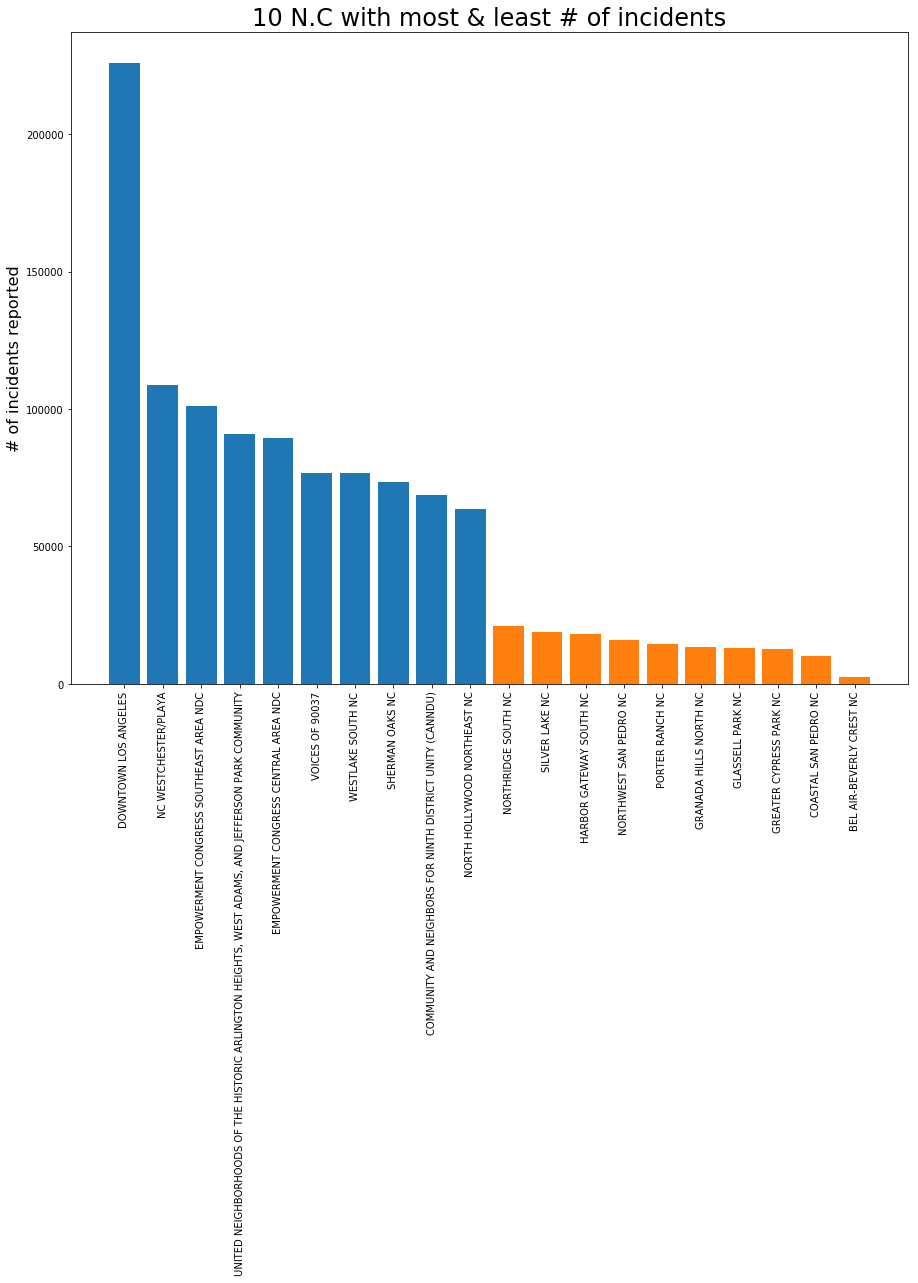

In [23]:
plt.figure(figsize=(15,12))

plt.bar(top_10_nc_response.index, top_10_nc_response.values)
plt.bar(bottom_10_nc_response.index, bottom_10_nc_response.values)


plt.ylabel('# of incidents reported', fontsize=16)
plt.title('10 N.C with most & least # of incidents', fontsize=24)
plt.xticks(rotation=90);

This plot displays the 10 fire-station departments with the most incidents responded to and the least incidents responded to. This obviously aligns with the Neighborhood Councils plot. Fire-Station 9 is the fire-station that is within the DTLA N.C

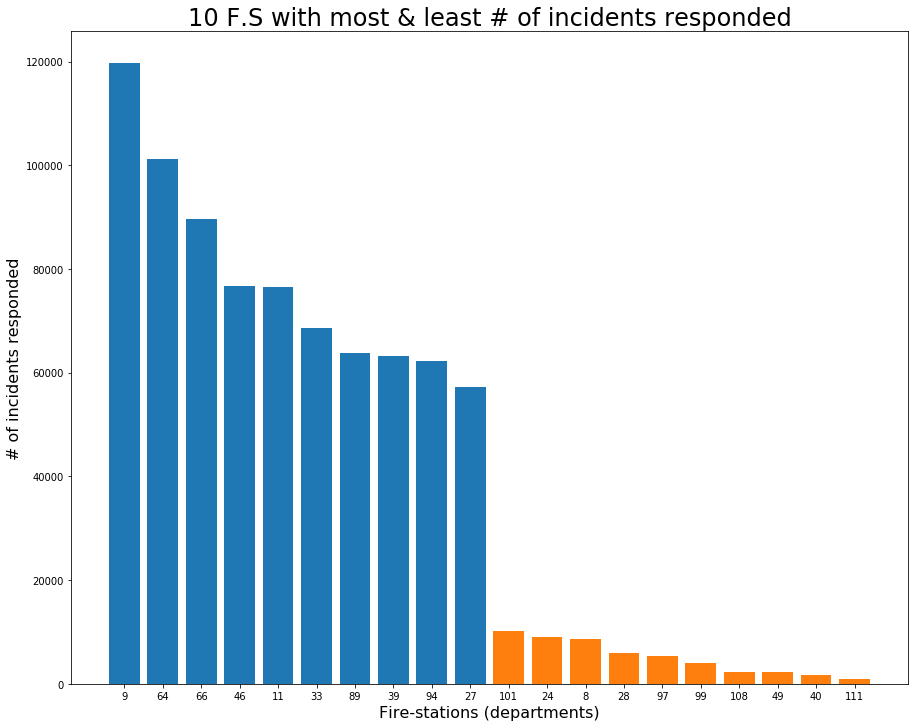

In [24]:
top_10_fs = lafd.groupby('first_in_district')['first_in_district'].count().sort_values(ascending=False).head(10)
bottom_10_fs = lafd.groupby('first_in_district')['first_in_district'].count().sort_values().head(10).sort_values(ascending=False)

plt.figure(figsize=(15,12))

plt.bar(top_10_fs.index.astype('str'), top_10_fs.values)
plt.bar(bottom_10_fs.index.astype('str'), bottom_10_fs.values)

plt.xlabel('Fire-stations (departments)', fontsize=16)
plt.ylabel('# of incidents responded', fontsize=16)
plt.title('10 F.S with most & least # of incidents responded', fontsize=24);

### All Stations Response Metric Data (Aggregate Averages):

Remember what the LA Times reported, "the Federal guidelines call for first responders to arrive on scene in under five minutes 90% of the time." Therefore, we will now take a look at the data and see if the LAFD meets the Federal guidelines for emergency calls in recent years.

We will use the All Stations Response Metrics dataset that is provided by the lacity database website. This dataset includes the averages of the aggregate response time for the LAFD depending on the year, month, and fire-station department. Unfortunately the dataset does not provide us the Neighborhood Council name that the incident took place in. As a result, we will add the N.C names by matching it with the fire-station department (district) that is within the region of the respective N.C.

* **Assumption:** *District means the CLOSEST fire-station department that responded to the call of the indicent. Therefore, the incident location SHOULD BE in the boundaries of the Neighborhood Council*

In [25]:
fs_list = list(reverse_dict.keys())

response = pd.read_csv('./data/All_Stations_Response_Metrics.csv')
response.shape

(5610, 9)

We removed rows that contain districts (fire-station departments) that are NOT among the fire-station departments in any of the Neighborhood Councils. 

In [26]:
response = response[response['DISTRICT'].isin(fs_list)]
response['nc_name'] = response['DISTRICT'].map(reverse_dict)
response.columns = [col.replace(' ', '_').lower() for col in response.columns]
print(response.shape)

(5225, 10)


In [27]:
response.head()

,year,district,month,average_lafd_turnout_time_in_district_-_non-ems,average_lafd_turnout_time_in_district_-_ems,average_lafd_travel_time__in_district_-_non-ems,average_lafd_travel_time_in_district_-_ems,incident_count_in_district_-_non-ems,incident_count_in_district_-_ems,nc_name
0,2013,1,Jan,0:01:22,0:01:10,0:04:39,0:04:17,45,183,LINCOLN HEIGHTS NC
1,2013,1,Feb,0:01:19,0:01:12,0:03:47,0:04:16,38,165,LINCOLN HEIGHTS NC
2,2013,1,Mar,0:01:20,0:01:13,0:04:05,0:04:17,44,174,LINCOLN HEIGHTS NC
3,2013,1,Apr,0:01:18,0:01:10,0:04:59,0:04:03,45,173,LINCOLN HEIGHTS NC
4,2013,1,May,0:01:16,0:01:16,0:04:30,0:04:16,53,234,LINCOLN HEIGHTS NC


In [28]:
response.isnull().sum().sum()

0

**Turnout Time:**
* The time interval between the activation of station alerting devices to when first responders put on their PPE3 and are aboard apparatus and en-route (wheels rolling). Both station alarm and en-route times are required to measure this for each unit that responds.

**Travel Time:**
* The time interval that begins when the first unit is en route to the incident and ends upon arrival of any of the units first on scene. This requires one valid en-route time and one valid on-scene time for the incident. Travel time can differ considerably amongst

[Data Dictionary](http://www.lafd.org/sites/default/files/pdf_files/PublicFacingDoc_Process%20v%202.0_101514.pdf)

We converted the time columns into readible seconds. (example: 70 = 1 minute 10 seconds)

In [29]:
response['avg_travel_time_ems']= pd.to_datetime(response[
    'average_lafd_travel_time_in_district_-_ems']).dt.minute * 60 + pd.to_datetime(response[
    'average_lafd_travel_time_in_district_-_ems']).dt.second
response['avg_travel_time_non_ems']= pd.to_datetime(response[
    'average_lafd_travel_time__in_district_-_non-ems']).dt.minute * 60 + pd.to_datetime(response[
    'average_lafd_travel_time__in_district_-_non-ems']).dt.second
response['avg_turnout_time_non_ems']= pd.to_datetime(response[
    'average_lafd_turnout_time_in_district_-_non-ems']).dt.minute * 60 + pd.to_datetime(response[
    'average_lafd_turnout_time_in_district_-_non-ems']).dt.second
response['avg_turnout_time_ems']= pd.to_datetime(response[
    'average_lafd_turnout_time_in_district_-_ems']).dt.minute * 60 + pd.to_datetime(response[
    'average_lafd_turnout_time_in_district_-_ems']).dt.second

In [30]:
response.drop(columns=['average_lafd_travel_time_in_district_-_ems',
                       'average_lafd_travel_time__in_district_-_non-ems',
                       'average_lafd_turnout_time_in_district_-_non-ems',
                       'average_lafd_turnout_time_in_district_-_ems'], inplace=True)

In [31]:
response.head()

,year,district,month,incident_count_in_district_-_non-ems,incident_count_in_district_-_ems,nc_name,avg_travel_time_ems,avg_travel_time_non_ems,avg_turnout_time_non_ems,avg_turnout_time_ems
0,2013,1,Jan,45,183,LINCOLN HEIGHTS NC,257,279,82,70
1,2013,1,Feb,38,165,LINCOLN HEIGHTS NC,256,227,79,72
2,2013,1,Mar,44,174,LINCOLN HEIGHTS NC,257,245,80,73
3,2013,1,Apr,45,173,LINCOLN HEIGHTS NC,243,299,78,70
4,2013,1,May,53,234,LINCOLN HEIGHTS NC,256,270,76,76


#### **Average wait time for LAFD arrival:**

In [32]:
def response_check(df, column):
    five_min_less = df[df[column] < 300]
    
    pct_five_min_less = (five_min_less[column].count() / df[column].count()) * 100
    print(f'{column} responded in less than 5 mins:', '{:.2f}'.format(pct_five_min_less), '%')

In [33]:
response_check(response, 'avg_travel_time_ems')
response_check(response, 'avg_travel_time_non_ems')

avg_travel_time_ems responded in less than 5 mins: 88.54 %
avg_travel_time_non_ems responded in less than 5 mins: 81.89 %


#### **Average wait time for LAFD arrival by year:**

After the 2008 scandal, the LAFD and Mayor Eric Garcetti both made a pledge to speed up Fire Department responses to emergencies in order to meet Federal guidelines consistently. However, the result states otherwise. The outcome is somewhat surprising and also quite unfortunate. Based on the plots below, we can see that the average travel time by LAFD first-unit respondents has increased from the year of 2013 to 2017. The average travel time for non-EMS related incidents in the year of 2015 has decreased a bit from the year before; however, the very next year it increased. On the other hand, the average travel time for EMS-related incidents has consistently increased throughout the years. From 2013 the average travel time increased by nearly half a minute in 2017, this is a 10% increase in time. 

At this point, we should consider looking into the reasons why response times are increasing instead of decreasing. 
* Perhaps the distance in some parts of the Los Angeles County make it extremely difficult for fire-fighters to arrive at the location quicker? 
* Perhaps there is some inefficiency when it comes to allocation of personnel and equipment? 
* Perhaps the closest fire-station to the incident location is in another call?


Both the average travel time for EMS and NON-EMS fall short of the Federal guidelines of meeting emergency calls in under 5 minutes 90 percent of the times. According to the data-dictionary, all the data are emergency related calls. EMS category in this case, includes incident types that require minimum personal protective equipments (PPE) and a turnout time of 60 seconds. The majority of the incidents reported in this dataset are medical in nature and as a result do not require protective equipments for the fire-fighters. The NON-EMS category are incidents that require full PPE and a turnout time of 80 seconds. Majority of these incidents require fire tools and equipments. 

Based on the following information, it makes sense that the average travel time for NON-EMS calls are longer in nature; as it requires more preparation. However for that very reason, we must find ways to eliminate the processing time for response times, especially the NON-EMS related calls as those are more of a priority in many cases. 

In [34]:
response.loc[response[response.month == 'Overall']['month'].index, 'month'] = 'Overall 2013'

# Overall is Overall for year 2013

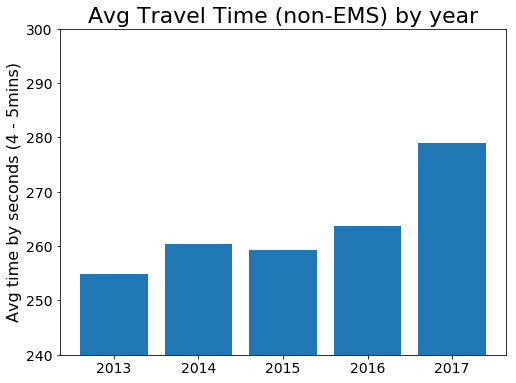

In [35]:
plt.figure(figsize=(8,6))
plt.bar(response.groupby(['year'])[['avg_travel_time_non_ems']].mean().sort_values(by='year').index, 
        response.groupby(['year'])[['avg_travel_time_non_ems']].mean().sort_values(by='year')['avg_travel_time_non_ems'])
plt.ylim(240,300)
plt.ylabel('Avg time by seconds (4 - 5mins)', fontsize=16)
plt.yticks(fontsize=14)
plt.title('Avg Travel Time (non-EMS) by year', fontsize=22)
plt.xticks(fontsize=14);

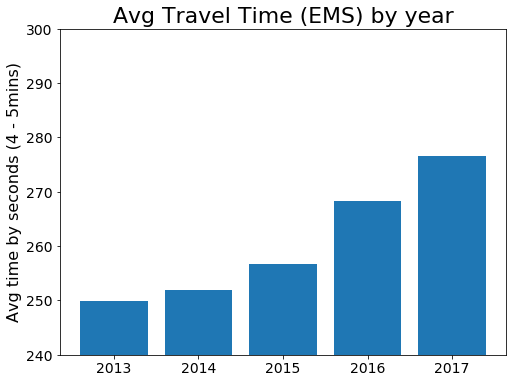

In [36]:
plt.figure(figsize=(8,6))
plt.bar(response.groupby(['year'])[['avg_travel_time_ems']].mean().sort_values(by='year').index, 
        response.groupby(['year'])[['avg_travel_time_ems']].mean().sort_values(by='year')['avg_travel_time_ems'])
plt.ylim(240,300)
plt.ylabel('Avg time by seconds (4 - 5mins)', fontsize=16)
plt.yticks(fontsize=14)
plt.title('Avg Travel Time (EMS) by year', fontsize=22)
plt.xticks(fontsize=14);

#### **Average wait time for LAFD arrival by season:**

In [37]:
winter = ['Dec', 'Jan', 'Feb']
spring = ['Mar', 'Apr', 'May']
summer = ['Jun', 'Jul', 'Aug']
fall = ['Sep', 'Oct', 'Nov']

seasons = []

for month in response['month']:
    if month in winter:
        seasons.append('winter')
    elif month in spring:
        seasons.append('spring')
    elif month in summer:
        seasons.append('summer')
    elif month in fall:
        seasons.append('fall')
    else:
        seasons.append(month)
        
response.insert(3, 'season', seasons)

In [38]:
response.head(2)

,year,district,month,season,incident_count_in_district_-_non-ems,incident_count_in_district_-_ems,nc_name,avg_travel_time_ems,avg_travel_time_non_ems,avg_turnout_time_non_ems,avg_turnout_time_ems
0,2013,1,Jan,winter,45,183,LINCOLN HEIGHTS NC,257,279,82,70
1,2013,1,Feb,winter,38,165,LINCOLN HEIGHTS NC,256,227,79,72


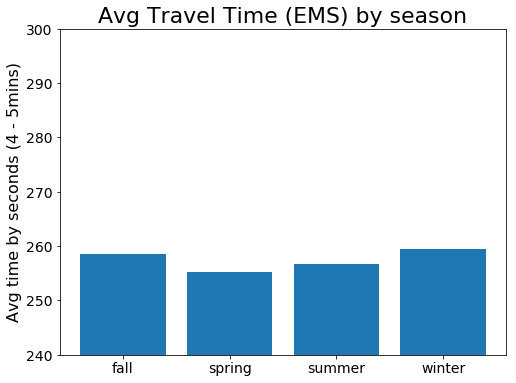

In [39]:
plt.figure(figsize=(8,6))
plt.bar(response.groupby(['season'])[['avg_travel_time_ems']].mean().tail(4).index, 
        response.groupby(['season'])[['avg_travel_time_ems']].mean().tail(4)['avg_travel_time_ems'])
plt.ylim(240,300)
plt.ylabel('Avg time by seconds (4 - 5mins)', fontsize=16)
plt.yticks(fontsize=14)
plt.title('Avg Travel Time (EMS) by season', fontsize=22)
plt.xticks(fontsize=14);

In [40]:
response.to_csv('./data/new_all_stations_response_metrics.csv')